   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.3 MB/s eta 0:00:00
Combined data shape: (1100, 23)
Columns available: ['Unnamed: 0', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD', 'source']

=== SCENARIO 1 (with A1–A10) Results (3x GroupKFold across sources) ===
          model       acc      prec       rec        f1       auc
0  GENZ-Contrib  0.990809  0.973856  0.995872  0.984395  0.999890
1            LR  0.986269  0.955657  1.000000  0.976249  0.999993
2           ANN  0.982955  0.946667  1.000000  0.971014  0.999911
3           XGB  0.962093  0.923433  0.981163  0.949730  0.997292
4            RF  0.925570  0.914836  0.921611  0.915635  0.986707
5           SVM  0.951679  0.963255  0.854141  0.899046  0.974336
6           KNN  0.911037  0.822727  0.989981  0.894747 

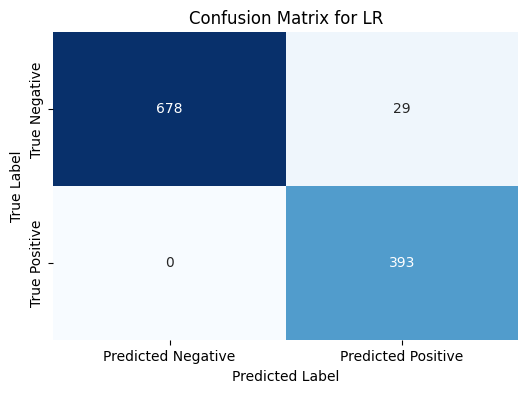

Metrics:
  Accuracy: 0.9736
  Precision: 0.9313
  Recall: 1.0000
  F1-Score: 0.9644

--- SVM ---
Confusion Matrix:
[[693  14]
 [ 81 312]]


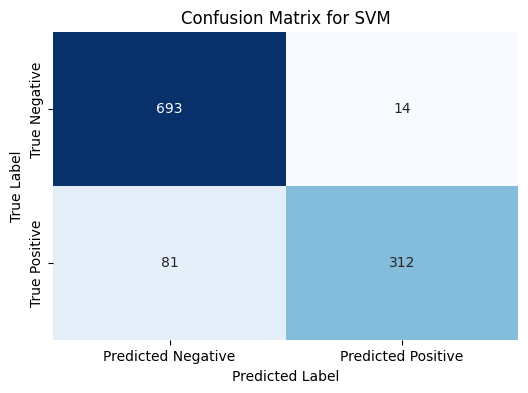

Metrics:
  Accuracy: 0.9136
  Precision: 0.9571
  Recall: 0.7939
  F1-Score: 0.8679

--- KNN ---
Confusion Matrix:
[[592 115]
 [  3 390]]


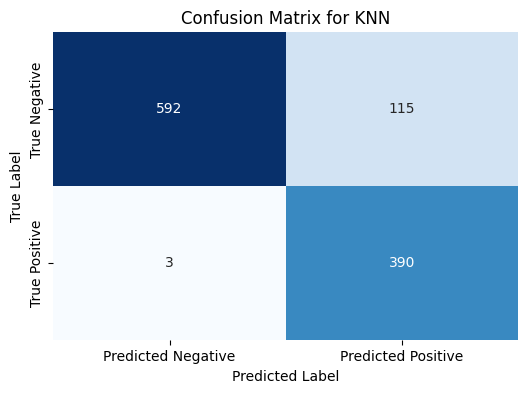

Metrics:
  Accuracy: 0.8927
  Precision: 0.7723
  Recall: 0.9924
  F1-Score: 0.8686

--- RF ---
Confusion Matrix:
[[662  45]
 [ 25 368]]


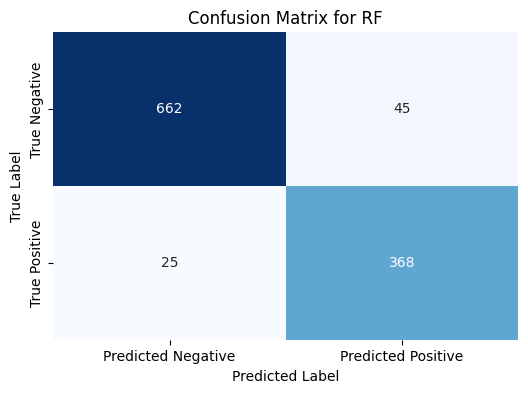

Metrics:
  Accuracy: 0.9364
  Precision: 0.8910
  Recall: 0.9364
  F1-Score: 0.9132

--- XGB ---
Confusion Matrix:
[[660  47]
 [  6 387]]


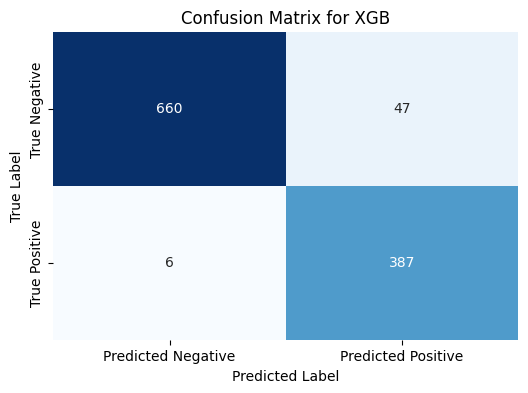

Metrics:
  Accuracy: 0.9518
  Precision: 0.8917
  Recall: 0.9847
  F1-Score: 0.9359

--- ANN ---
Confusion Matrix:
[[671  36]
 [  0 393]]


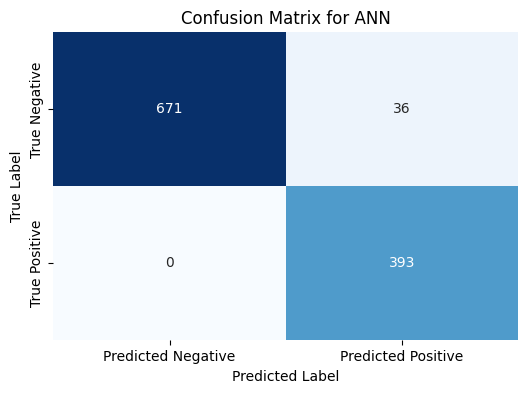

Metrics:
  Accuracy: 0.9673
  Precision: 0.9161
  Recall: 1.0000
  F1-Score: 0.9562

--- GENZ-Contrib ---
Confusion Matrix:
[[691  16]
 [  2 391]]


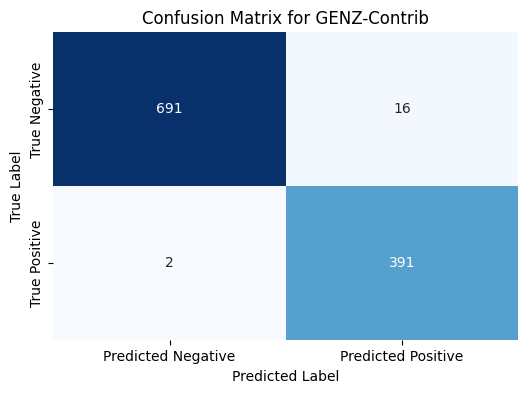

Metrics:
  Accuracy: 0.9836
  Precision: 0.9607
  Recall: 0.9949
  F1-Score: 0.9775

Generating Performance Metrics Plots for Scenario 1 Models:


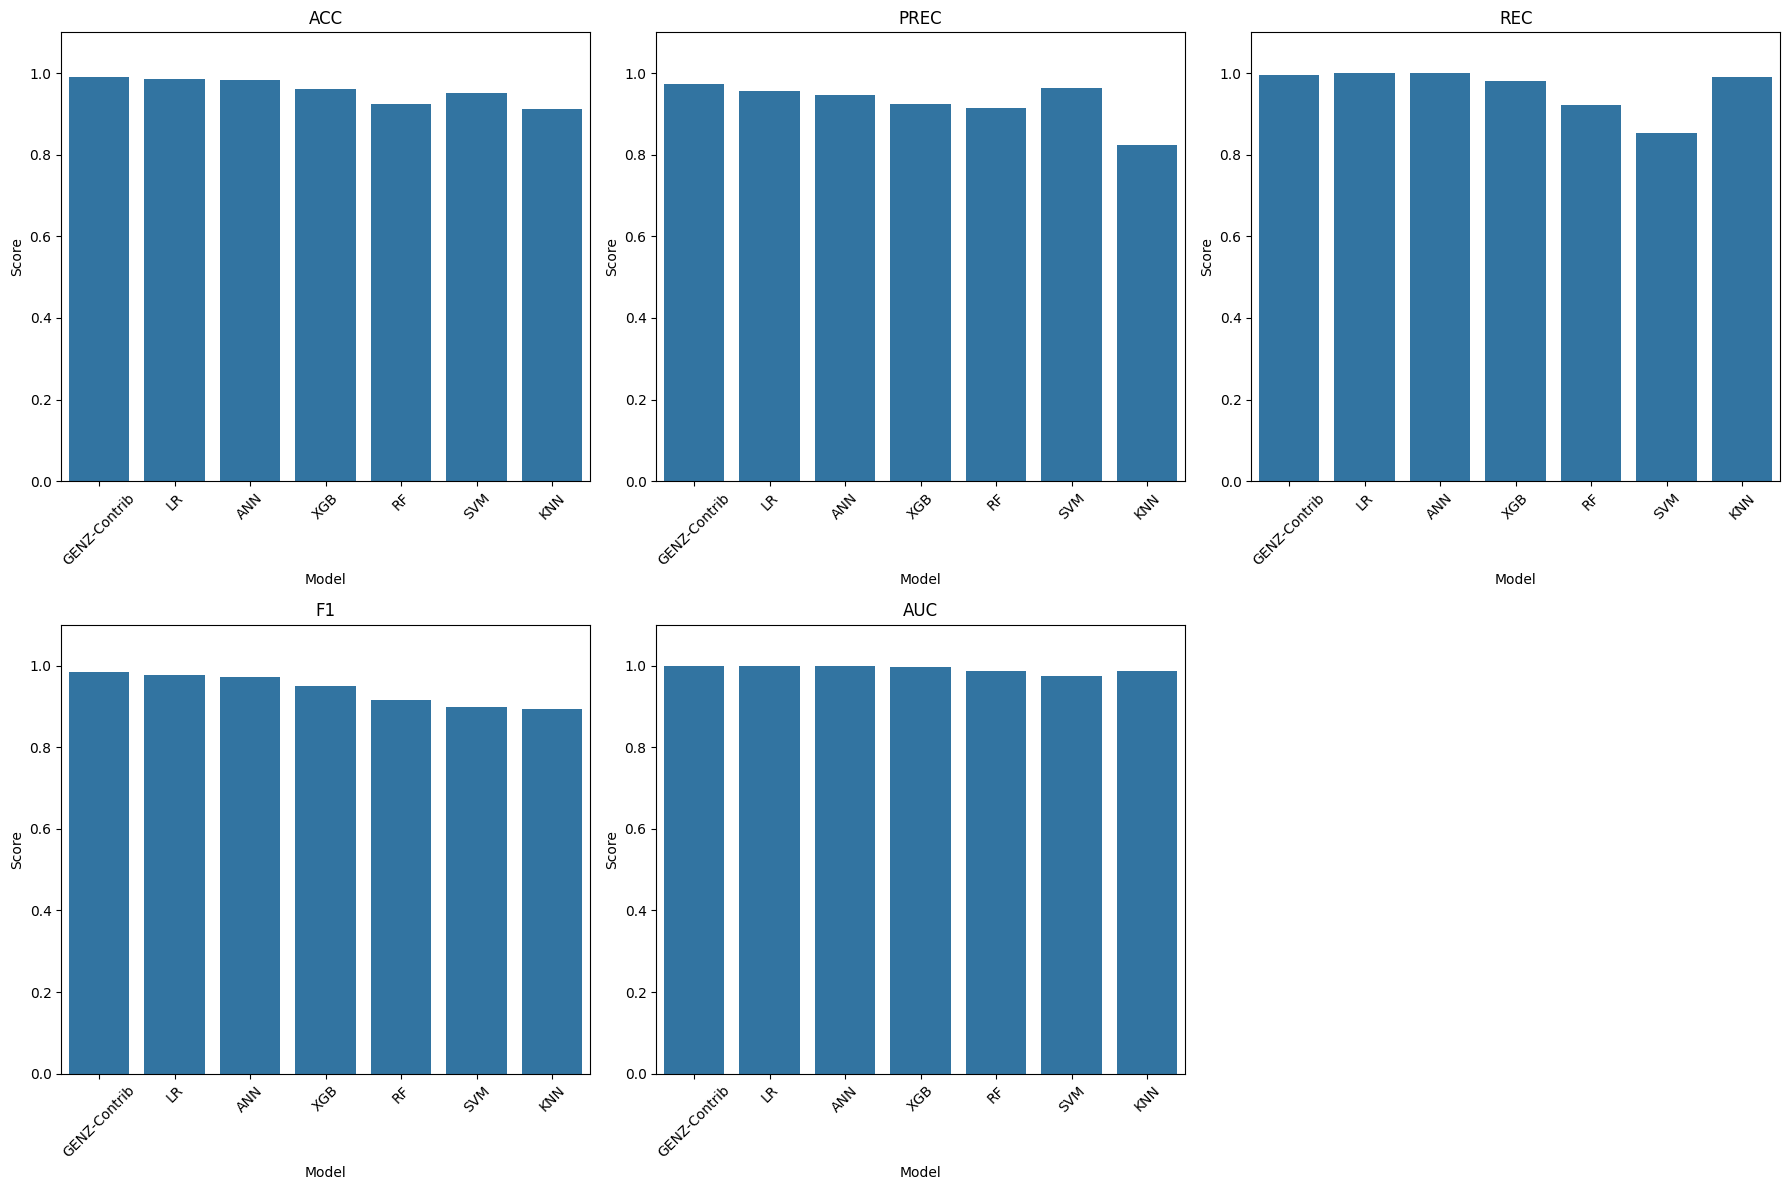


Performance Metrics Table for Scenario 1 Models:


,model,acc,prec,rec,f1,auc
0,GENZ-Contrib,0.990809,0.973856,0.995872,0.984395,0.999890
1,LR,0.986269,0.955657,1.000000,0.976249,0.999993
2,ANN,0.982955,0.946667,1.000000,0.971014,0.999911
3,XGB,0.962093,0.923433,0.981163,0.949730,0.997292
4,RF,0.925570,0.914836,0.921611,0.915635,0.986707
5,SVM,0.951679,0.963255,0.854141,0.899046,0.974336
6,KNN,0.911037,0.822727,0.989981,0.894747,0.985804



Generating Feature Correlation Plot for Scenario 1:


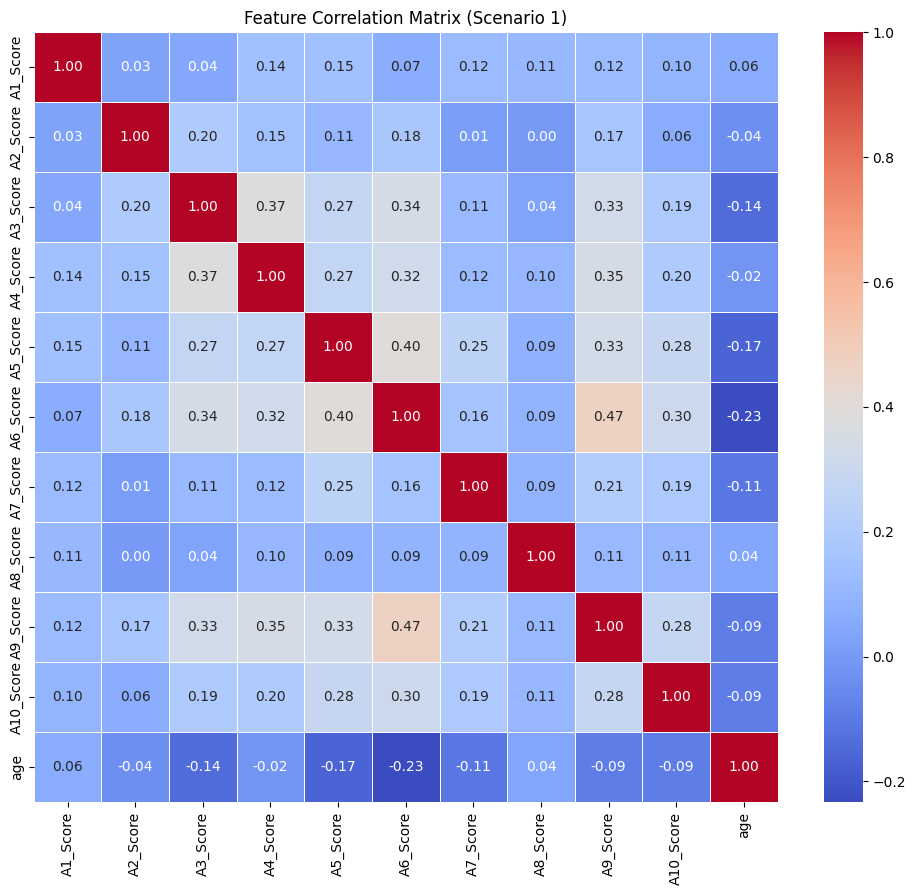


Saved: /content/scenario1_groupcv_results.csv


In [ ]:
# ---------- Setup: Install Libraries ----------
!pip -q install imbalanced-learn shap xgboost lightgbm category-encoders tensorflow keras scikeras --quiet

# ---------- Imports ----------
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ANN imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier


# Encoding
import category_encoders as ce

# Explainability
import shap
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
tf.random.set_seed(42)

# Load Data

def load_with_source(path, source_name):
    df = pd.read_csv(path)
    df['source'] = source_name
    return df

d1 = load_with_source('/content/Autism-Adolescent-Data.csv', 'adolescent')
d2 = load_with_source('/content/Autism-Adult_Data.csv', 'adult')
d3 = load_with_source('/content/Autism-Child-Data.csv', 'child')
df = pd.concat([d1, d2, d3], axis=0, ignore_index=True)

print("Combined data shape:", df.shape)
print("Columns available:", df.columns.tolist())


#  Data Cleaning and Preparation

if 'Class/ASD' in df.columns:
    df = df.rename(columns={'Class/ASD': 'target'})

# Drop irrelevant or leaking columns
drop_cols = [c for c in ['Unnamed: 0','result','austim','jundice','age_desc'] if c in df.columns]
df = df.drop(columns=drop_cols)

# Standardize missing value
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].replace(['?', '-', 'null', 'None', 'NA', 'na', ' '], np.nan)


df['target'] = df['target'].map({'YES':1, 'Yes':1, 'yes':1, 'NO':0, 'No':0, 'no':0}).astype('Int64')

# Remove rows with missing
df = df.dropna(subset=['target']).reset_index(drop=True)
df['target'] = df['target'].astype(int)

# Convert age to numeri
if 'age' in df.columns:

    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age_bin'] = pd.cut(df['age'], bins=[0,10,18,30,50,120], labels=['child','teen','young','adult','senior'])
else:
    df['age'] = np.nan
    df['age_bin'] = np.nan

# Identify feature types
cat_like = [c for c in ['gender','ethnicity','contry_of_res','used_app_before','relation','age_bin'] if c in df.columns]
num_like = [c for c in ['age'] if c in df.columns]
aq_cols = [c for c in df.columns if c.lower().startswith('a') and 'score' in c.lower()] # A1-A10 scores

#  Define Evaluation Metrics
def metrics_table(y_true, y_prob, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc)


s1_features = aq_cols + num_like + [c for c in cat_like if c != 'age_bin'] + (['age_bin'] if 'age_bin' in df.columns else [])
s1_features = [c for c in s1_features if c in df.columns]


if 'source' in s1_features:
    s1_features.remove('source')

# Preprocessing Pipelines : Impute and One-Hot Encode Categorical

s1_cat = [c for c in s1_features if df[c].dtype == object or str(df[c].dtype).startswith('category')]
s1_num = [c for c in s1_features if c not in s1_cat]

s1_pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imp',    SimpleImputer(strategy='median')),
            ('scale',  StandardScaler())
        ]), s1_num),
        ('cat', Pipeline(steps=[
            ('imp',    SimpleImputer(strategy='most_frequent')),
            ('ohe',    OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), s1_cat)
    ],
    remainder='drop'
)

# models
s1_models = {
    'LR'  : LogisticRegression(max_iter=2000),
    'SVM' : SVC(kernel='rbf', probability=True, C=5, gamma='scale'),
    'KNN' : KNeighborsClassifier(n_neighbors=7),
    'RF'  : RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42),
    'XGB' : XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, random_state=42, eval_metric='logloss', n_jobs=-1, tree_method='hist'
    ),
}

# ANN Model Definition
def create_s1_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# ANN Model using KerasClassifier wrapper
s1_models['ANN'] = KerasClassifier(model=create_s1_nn_model, verbose=0, epochs=50, batch_size=32)

# Scenario 1 Stacking Classifier
s1_stack = StackingClassifier(
    estimators=[
        ('rf', s1_models['RF']),
        ('xgb', s1_models['XGB']),
        ('svm', s1_models['SVM']),
        ('lr', s1_models['LR'])
    ],
    final_estimator=LogisticRegression(max_iter=3000),
    passthrough=False, n_jobs=-1
)

# Add Stacking Classifier to evaluation models
s1_models_eval = {**s1_models, 'GENZ-Contrib': s1_stack}


# Build Full Pipeline
def make_pipeline_s1(model):
    # Pipeline for Scenario 1: Preprocessing followed by the model
    return Pipeline([
        ('prep', s1_pre),
        ('clf',  model)
    ])

#GroupKFold Cross-Validation Evaluation
def evaluate_nested(df, features, make_pipe, models_dict, label='Scenario'):
    X = df[features + ['source']].copy()
    y = df['target'].values
    groups = X['source'].values
    X = X.drop(columns=['source'])

    outer = GroupKFold(n_splits=3)
    results_all = []
    all_model_predictions = {}


    num_imputer_full = SimpleImputer(strategy='median')
    cat_imputer_full = SimpleImputer(strategy='most_frequent')

    # numerical and categorical columns
    feature_cols = list(features)
    num_cols = [col for col in feature_cols if df[col].dtype != 'object' and not str(df[col].dtype).startswith('category')]
    cat_cols = [col for col in feature_cols if col not in num_cols]

    if num_cols:
        num_imputer_full.fit(X[num_cols])
    if cat_cols:
        cat_imputer_full.fit(X[cat_cols])


    for mdl_name, mdl in models_dict.items():
        outer_metrics = []
        fold_y_true = []
        fold_y_pred = []
        fold_y_prob = []

        for train_idx, test_idx in outer.split(X, y, groups):

            # Split data
            X_tr, X_te = X.iloc[train_idx][features], X.iloc[test_idx][features]
            y_tr, y_te = y[train_idx], y[test_idx]


            X_tr_imputed = X_tr.copy()
            X_te_imputed = X_te.copy()

            if num_cols:
                X_tr_imputed[num_cols] = num_imputer_full.transform(X_tr[num_cols])
                X_te_imputed[num_cols] = num_imputer_full.transform(X_te[num_cols])
            if cat_cols:
                X_tr_imputed[cat_cols] = cat_imputer_full.transform(X_tr[cat_cols])
                X_te_imputed[cat_cols] = cat_imputer_full.transform(X_te[cat_cols])


            pipe = make_pipe(mdl)

            # Handle ANN separately for prediction
            if mdl_name == 'ANN':

                 X_tr_transformed_shape = s1_pre.fit_transform(X_tr_imputed).shape
                 input_dim = X_tr_transformed_shape[1]

                 ann_model_instance = KerasClassifier(model=lambda: create_s1_nn_model(input_dim), verbose=0, epochs=50, batch_size=32)

                 pipe = Pipeline([
                     ('prep', s1_pre),
                     ('clf',  ann_model_instance)
                 ])

                 pipe.fit(X_tr_imputed, y_tr)

                #keras
                 X_te_transformed = pipe.named_steps['prep'].transform(X_te_imputed)
                 y_prob = pipe.named_steps['clf'].predict_proba(X_te_transformed)[:,1]
                 y_pred = (y_prob>=0.5).astype(int)

            else: #  other models

                if mdl_name in ['XGB','RF']:
                    param = {}
                    if mdl_name=='RF':
                        param = {'clf__n_estimators':[400,600], 'clf__max_depth':[None,10], 'clf__min_samples_leaf':[1,2,3]}
                    elif mdl_name=='XGB':
                        param = {'clf__n_estimators':[500,700], 'clf__max_depth':[4,6], 'clf__learning_rate':[0.03,0.07]}

                    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
                    search = RandomizedSearchCV(pipe, param, n_iter=4, cv=inner, n_jobs=-1,
                                                scoring='f1', random_state=42, verbose=0)
                    search.fit(X_tr_imputed, y_tr)
                    best = search.best_estimator_
                    y_prob = best.predict_proba(X_te_imputed)[:,1]
                    y_pred = (y_prob>=0.5).astype(int)


                else: # For LR, SVM, KNN
                    pipe.fit(X_tr_imputed, y_tr)
                    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
                        y_prob = pipe.predict_proba(X_te_imputed)[:,1]
                    else:

                        if hasattr(pipe.named_steps['clf'], 'decision_function'):
                            dfc = pipe.decision_function(X_te_imputed)

                            dfc = (dfc - dfc.min()) / (dfc.max() - dfc.min() + 1e-9)
                            y_prob = dfc
                        else:
                            y_prob = None
                    y_pred = pipe.predict(X_te_imputed)


            outer_metrics.append(metrics_table(y_te, y_prob, y_pred))


            fold_y_true.extend(y_te)
            fold_y_pred.extend(y_pred)
            fold_y_prob.extend(y_prob)

        avg = pd.DataFrame(outer_metrics).mean().to_dict()
        results_all.append({'model': mdl_name, **avg})

        # Store aggregated
        all_model_predictions[mdl_name] = {
            'y_true': np.array(fold_y_true),
            'y_pred': np.array(fold_y_pred),
            'y_prob': np.array(fold_y_prob) if any(p is not None for p in fold_y_prob) else None
        }


    res = pd.DataFrame(results_all).sort_values('f1', ascending=False).reset_index(drop=True)
    print(f"\n=== {label} Results (3x GroupKFold across sources) ===") # Updated print statement
    print(res[['model','acc','prec','rec','f1','auc']])
    return res, all_model_predictions # Return results table and predictions


res_s1, s1_predictions = evaluate_nested(df, s1_features, make_pipeline_s1, s1_models_eval, label='SCENARIO 1 (with A1–A10)')

#  Confusion Matrices
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

if 's1_predictions' in locals():
    print("\nGenerating Confusion Matrices and Metrics for Scenario 1 Models:")
    for model_name, predictions in s1_predictions.items():
        y_true = predictions['y_true']
        y_pred = predictions['y_pred']
        y_prob = predictions['y_prob']


        cm = confusion_matrix(y_true, y_pred)

        print(f"\n--- {model_name} ---")
        print("Confusion Matrix:")
        print(cm)


        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['True Negative', 'True Positive'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print("Metrics:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall: {rec:.4f}")
        print(f"  F1-Score: {f1:.4f}")

else:
    print("Error: s1_predictions not found. Please ensure the evaluation step ran successfully.")


# Performance Metrics
print("\nGenerating Performance Metrics Plots for Scenario 1 Models:")
import matplotlib.pyplot as plt
import seaborn as sns


melted_results = res_s1.melt(id_vars='model', var_name='metric', value_name='score')


metrics_to_plot = ['acc', 'prec', 'rec', 'f1', 'auc']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()


for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x='model', y='score', data=melted_results[melted_results['metric'] == metric], ax=axes[i])
    axes[i].set_title(metric.upper())
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylim(0, 1.1)


axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Performance Metrics Table
print("\nPerformance Metrics Table for Scenario 1 Models:")
display(res_s1)


print("\nGenerating Feature Correlation Plot for Scenario 1:")
import matplotlib.pyplot as plt
import seaborn as sns


df_s1_features = df[s1_features]

# correlation matrix
correlation_matrix = df_s1_features.corr(numeric_only=True)

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix (Scenario 1)')
plt.show()


# ---------- Save Results
res_s1.to_csv('/content/scenario1_groupcv_results.csv', index=False)
print("\nSaved: /content/scenario1_groupcv_results.csv")